In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

import os
import pathlib

from tensorflow import keras

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
seed = 7
tf.random.set_seed(7)

In [5]:
os.getcwd()

'/kaggle/working'

In [6]:
dir_path = '/kaggle/input/stanford-dogs-dataset-traintest/cropped'

training_path = os.path.abspath(dir_path+'/train')
testing_path = os.path.abspath(dir_path+'/test')

training_dir = pathlib.Path(training_path).with_suffix('')
testing_dir = pathlib.Path(testing_path).with_suffix('')
train_image_count = len(list(training_dir.glob('*/*.jpg')))
test_image_count = len(list(testing_dir.glob('*/*.jpg')))
print(train_image_count)
print(test_image_count)


12000
8580


In [7]:
batch_size = 64
image_height = 224
image_width = 224

In [8]:
training_ds = keras.utils.image_dataset_from_directory(
  training_dir,
  seed=seed,
  validation_split = 0.2,
  subset = "training",
  image_size = (image_height, image_width),
  batch_size=batch_size)


Found 12000 files belonging to 120 classes.
Using 9600 files for training.


In [9]:
validation_ds = keras.utils.image_dataset_from_directory(
  training_dir,
  seed=seed,
  shuffle = False,
  validation_split = 0.15,
  subset = "validation",
  image_size = (image_height, image_width),
  batch_size=batch_size)

Found 12000 files belonging to 120 classes.
Using 1800 files for validation.


In [10]:
testing_ds = keras.utils.image_dataset_from_directory(
  testing_dir,
  seed=seed,
  shuffle = False,
  image_size = (image_height, image_width),
  batch_size=batch_size)

Found 8580 files belonging to 120 classes.


In [11]:
class_names = training_ds.class_names
len(class_names)

120

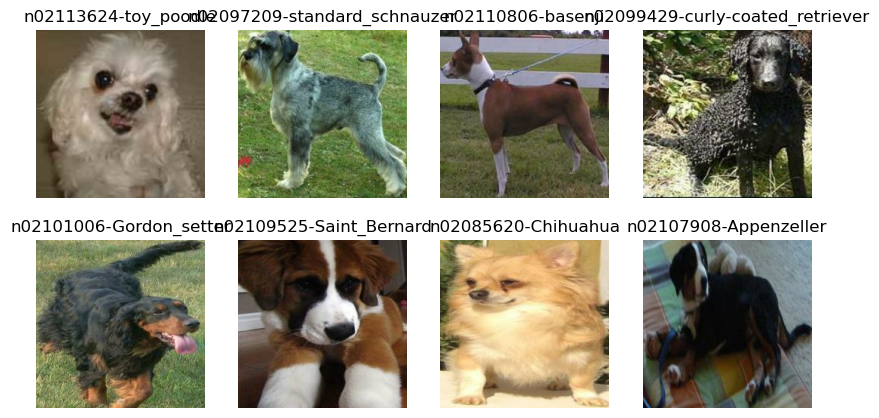

In [12]:
plt.figure(figsize=(10, 5))
for images, labels in training_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
num_classes = len(class_names)

model = keras.models.Sequential([
  keras.layers.Rescaling(1./255),
  keras.layers.RandomFlip("horizontal",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
  keras.layers.RandomRotation(0.1),
  keras.layers.RandomZoom(0.1),
  keras.layers.Conv2D(128, 3, strides = (1,1), padding='valid', activation='relu', input_shape = (224, 224, 3)),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(512, 3, padding='same', activation='leaky_relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(4096, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=30
history = model.fit(
  training_ds,
  validation_data=validation_ds,
  epochs=epochs
)
model.save('/kaggle/working/model17')

Epoch 1/30
 48/150 [========>.....................] - ETA: 16s - loss: 4.7990 - accuracy: 0.0081

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize = (10,4))
plt.ylim([0,1])
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.plot(range(epochs), [l/100 for l in val_loss], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

print(val_loss)

In [ ]:
model.save('/kaggle/working/model19')

In [ ]:
predictions = model.predict(testing_ds)
print(predictions)
print(type(predictions))

In [ ]:
for _, labels in testing_ds:
    print(labels)

In [ ]:
pred_norm = (predictions- np.min(predictions))/(np.max(predictions) - np.min(predictions))
print(pred_norm)
plt.cla()
plt.imshow(pred_norm, aspect = 'auto')

In [ ]:
predictions.shape

In [ ]:
testing_correct = np.concatenate([labels for _, labels in testing_ds])

In [ ]:
print(testing_correct)


In [ ]:
chihuahua_image_url = 'https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg'
chihuahua_image_path = keras.utils.get_file(origin = chihuahua_image_url)

img = keras.utils.load_img(
    chihuahua_image_path, target_size=(image_height, image_width)
)

In [ ]:
img_array1 = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array1, 0) # Create a batch

plt.axis(False)
plt.imshow(img_array1.astype(np.uint8))

prediction = model.predict(img_array)
# print(predictions[predictions > 0])
score = tf.nn.softmax(prediction[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
model = keras.models.load_model('/kaggle/working/model19')

In [ ]:
import zipfile

def zipfolder(foldername, target_dir):
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])
            
zipfolder('model19', '/kaggle/working/model19')